In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Задание 1

In [2]:
with open("top500.json", "rb") as f:
    comp_series = json.load(f)
comp_series = pd.DataFrame(comp_series).T.reset_index().rename(columns={'index': 'Date'})
top_1_by_date = comp_series[["Date", "#1"]]
top_1_by_date = pd.concat([top_1_by_date, pd.DataFrame(top_1_by_date['#1'].tolist(), columns=['value', 'order'])],
                          axis=1)

In [3]:
assert top_1_by_date['order'].nunique() == 1
top_1_by_date = top_1_by_date.loc[:, ['Date', 'value']]

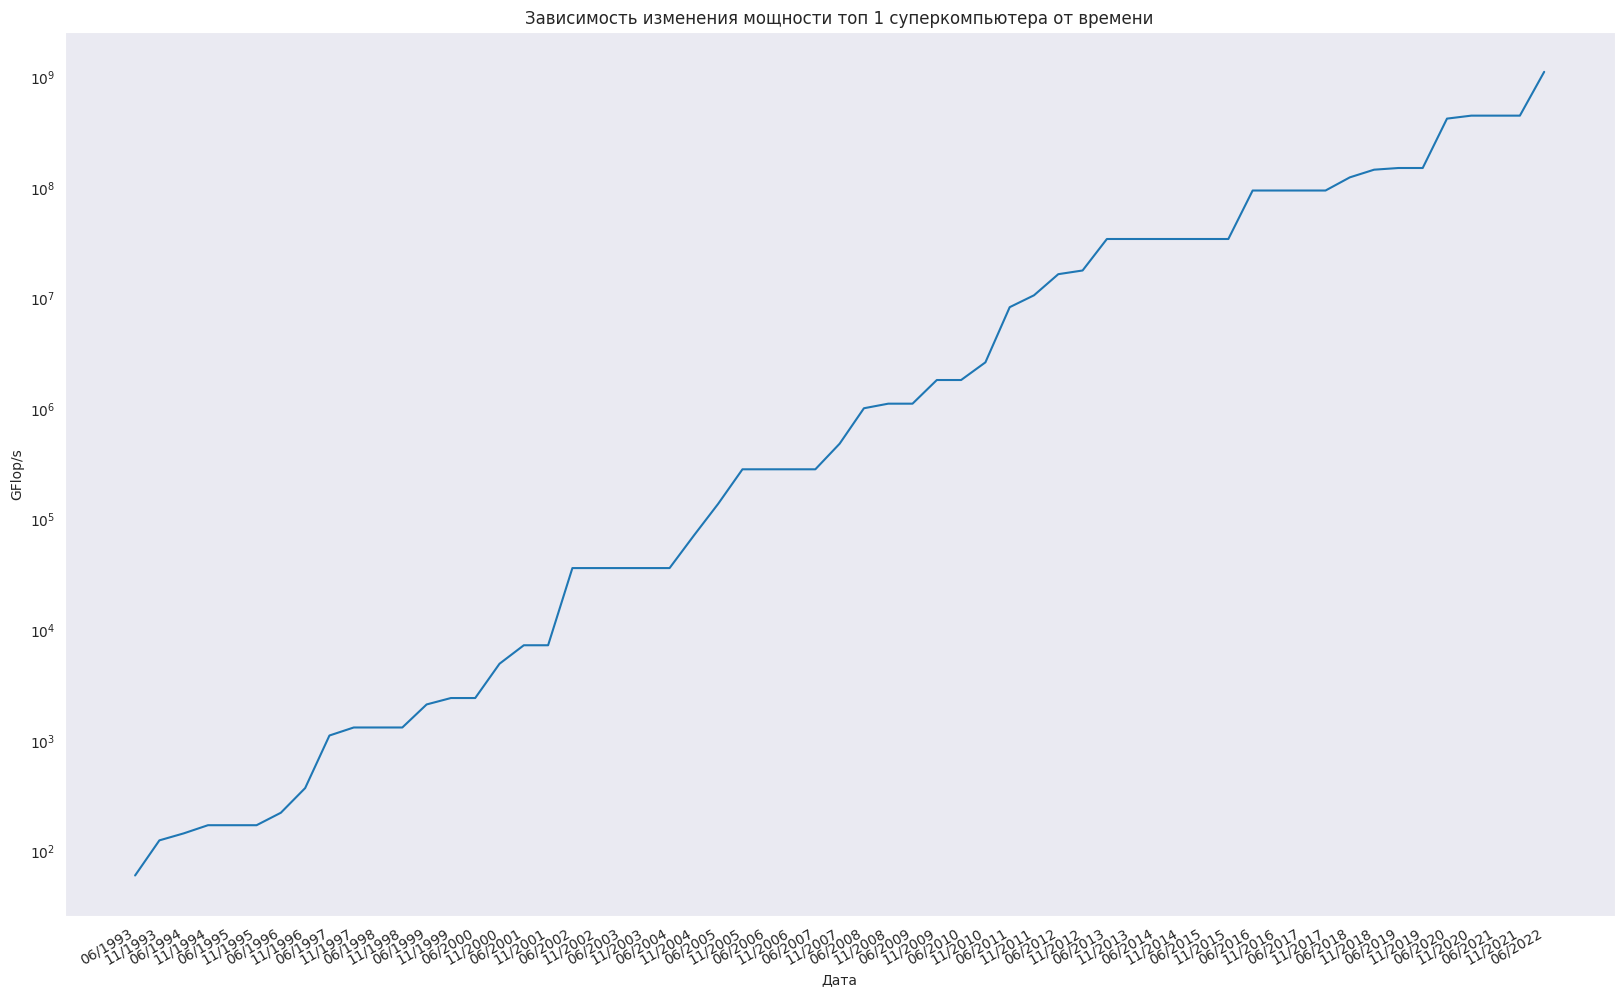

In [4]:
from matplotlib.pyplot import figure

figure(figsize=(20, 13))
plt.plot(top_1_by_date['Date'], top_1_by_date['value'])
plt.yscale('log')
plt.gcf().autofmt_xdate()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('GFlop/s')
plt.title('Зависимость изменения мощности топ 1 суперкомпьютера от времени')
plt.show()

### Анализ собранных данных
Из графика видно, если мощность отлогарифмировать, то зависимость мощности от времени становится линейной, однако, что линейного роста в бесконечности (да и в целом) не будет. Однажды наступит насыщение. Поэтому введем оптимистичную и консервативную оценку.

### оптимимистичная оценка:
 обучим линейную регрессию на отлогарифмированных данных. Так как временная шкала является равномерной, и промежутки между датами одинаковые, то даты закодируем просто:

In [5]:
data = top_1_by_date.copy(deep=True)
data['log_value'] = np.log(data['value'])
data['Date_encode'] = [i + 1 for i in range(data.shape[0])]

split_ratio = 0.7
train_part = data.iloc[:int(data.shape[0] * split_ratio), :]
test_part = data.iloc[int(data.shape[0] * split_ratio):, :]


In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [7]:
log_regressor = Ridge(fit_intercept=True, alpha=0.01)
log_regressor.fit(train_part['Date_encode'].values.reshape(-1, 1), train_part['log_value'].tolist())
print(f'Coefficients: w = {log_regressor.coef_}, b = {log_regressor.intercept_}')
preds = np.exp(log_regressor.predict(test_part['Date_encode'].values.reshape(-1, 1)))
Mae_val = MAE(test_part["value"].values, preds)
print(f'MSE = {MSE(test_part["value"].values, preds)}, MAE = {Mae_val}')

Coefficients: w = [0.32363375], b = 3.5743917339980555
MSE = 4.252089476904925e+18, MAE = 1183217110.6522276


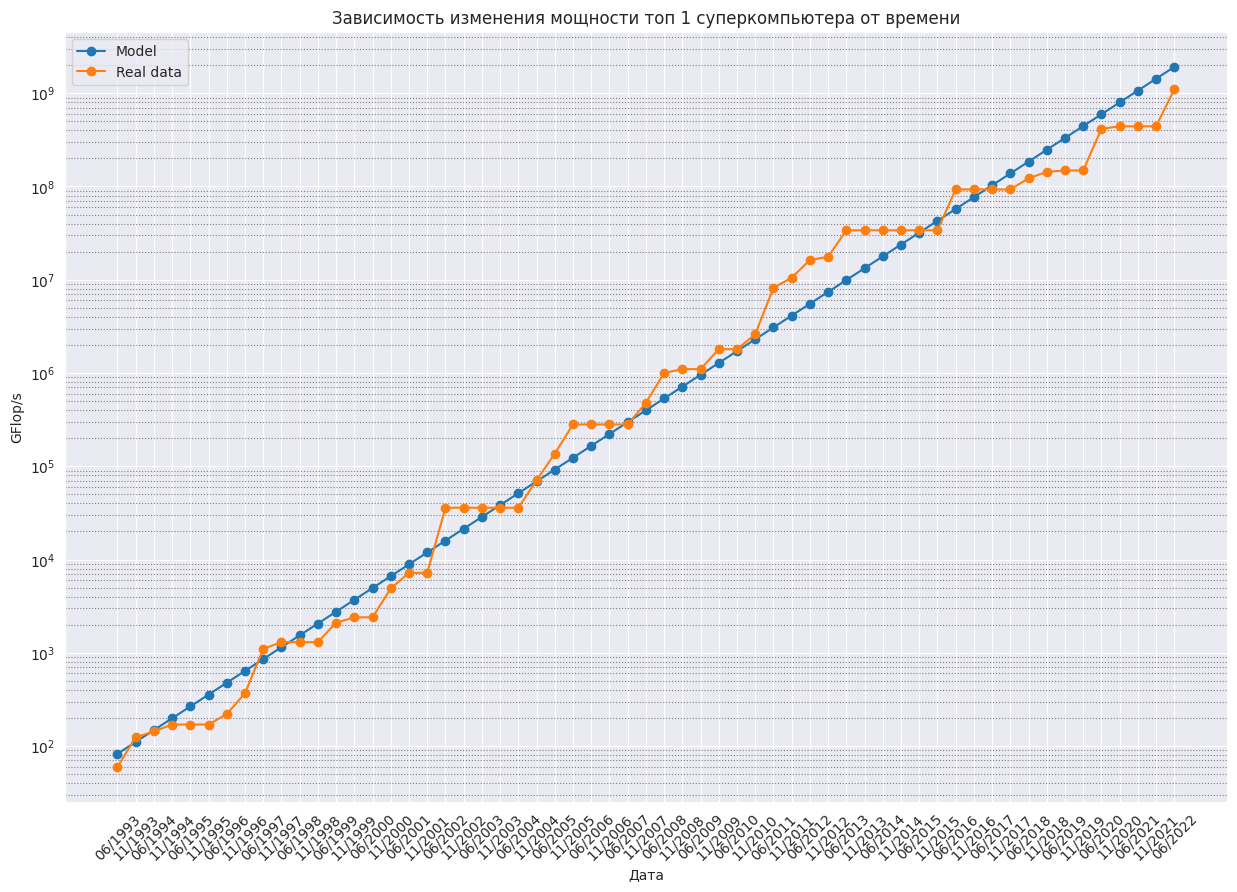

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.plot(data['Date'], np.exp(log_regressor.predict(data['Date_encode'].values.reshape(-1,1))), marker = 'o', label = 'Model')
ax.plot(data['Date'], data['value'], marker = 'o', label = 'Real data')
ax.set_xlabel('Дата')
ax.set_ylabel('GFlop/s')
ax.set_yscale('log')
ax.set_title('Зависимость изменения мощности топ 1 суперкомпьютера от времени')
ax.tick_params(axis ='x', rotation = 45)

ax.legend()
plt.show()

Видно, что со временем линейная модель начинает ошибаться

In [15]:
#для увеличения точности обучимся на всех данных
log_regressor = Ridge(fit_intercept=True, alpha=0.01)
log_regressor.fit(data['Date_encode'].values.reshape(-1, 1), data['log_value'].tolist())
preds = np.exp(log_regressor.predict([[data['Date_encode'].max()+6]]))
print(f"Таким образом производительсноть суперкомпьютеров на 05.2025 будет {round(preds[0]/1e9,1)}+-{round(Mae_val/1e9, 1)} GFlop/s")

Таким образом производительсноть суперкомпьютеров на 11.2022 будет 11.1+-1.2 GFlop/s


### консервативная оценка.
Для нее Пытался использовать различные функции с горизонтальными ассимптотами, однако при преобразовании таргета линейности не было, а что-то иное обучать, кроме линейных моделей, для экстраполяции на таких маленьких данных не хочется.

# Задание 2

In [16]:
top500_data = pd.read_csv("TOP500_202206.csv")
top500_data['Power (kW)'] = top500_data['Power (kW)'].str.replace(',','').astype(float)

<AxesSubplot: ylabel='Density'>

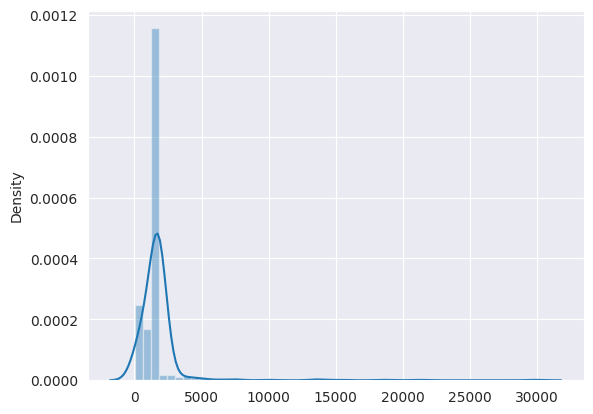

In [26]:
import seaborn as sns
sns.distplot(top500_data[~top500_data['Power (kW)'].isna()]['Power (kW)'].values)


In [27]:
top500_data['Power (kW)'] = top500_data['Power (kW)'].fillna(top500_data['Power (kW)'].mean())
KWH_sup_comp = top500_data['Power (kW)'] .sum()
KWH_ALL = 28214 * 1e12

In [28]:
print(f'Вот такую часть энергии потребляют суперкомпьютеры {(KWH_sup_comp * 1e3 * 24 * 365 / KWH_ALL) * 100} %')

Вот такую часть энергии потребляют суперкомпьютеры 0.027674253489690055 %


# Задание 3

In [29]:
import random

class Matrix(list):
    @classmethod
    def zeros(cls, shape):
        n_rows, n_cols = shape
        return cls([[0] * n_cols for i in range(n_rows)])

    @classmethod
    def random(cls, shape):
        M, (n_rows, n_cols) = cls(), shape
        for i in range(n_rows):
            M.append([random.randint(-255, 255)
                      for j in range(n_cols)])
        return M

    def transpose(self):
        n_rows, n_cols = self.shape
        return self.__class__(zip(*self))

    @property
    def shape(self):
        return ((0, 0) if not self else
                (len(self), len(self[0])))

Стандартная реализация Матричного перемножения

In [30]:
def matrix_product(X, Y):
    n_xrows, n_xcols = X.shape
    n_yrows, n_ycols = Y.shape
    Z = Matrix.zeros((n_xrows, n_ycols))
    for i in range(n_xrows):
        for j in range(n_xcols):
            for k in range(n_ycols):
                Z[i][k] += X[i][j] * Y[j][k]
    return Z

In [31]:
%%timeit
shape = 64, 64
X = Matrix.random(shape)
Y = Matrix.random(shape)
matrix_product(X, Y)

45.5 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Попробуем ускорить уменьшив обращения по индксу, функция getitem много требует

In [32]:
def matrix_product(X, Y):
    n_xrows, n_xcols = X.shape
    n_yrows, n_ycols = Y.shape
    Z = Matrix.zeros((n_xrows, n_ycols))
    for i in range(n_xrows):
        Xi = X[i]
        for k in range(n_ycols):
            acc = 0
            for j in range(n_xcols):
                acc += Xi[j] * Y[j][k]
            Z[i][k] = acc
    return Z

In [33]:
%%timeit
shape = 64, 64
X = Matrix.random(shape)
Y = Matrix.random(shape)
matrix_product(X, Y)

24.7 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Уберем лишние обращения по индексу из самого внутреннего цикла

In [34]:
def matrix_product(X, Y):
    n_xrows, n_xcols = X.shape
    n_yrows, n_ycols = Y.shape
    Z = Matrix.zeros((n_xrows, n_ycols))
    Yt = Y.transpose()  # <--
    for i, (Xi, Zi) in enumerate(zip(X, Z)):
        for k, Ytk in enumerate(Yt):
            Zi[k] = sum(Xi[j] * Ytk[j] for j in range(n_xcols))
    return Z

In [35]:
%%timeit
shape = 64, 64
X = Matrix.random(shape)
Y = Matrix.random(shape)
matrix_product(X, Y)

20.3 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Получилось в два раза быстрее, кайфуха, а мы всего лишь уменьшили использование $$__getitem__()$$